In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import time

In [151]:
# import customer information into dataframe

df_cust = pd.read_csv('twm_customer.csv', sep=';')
print(df_cust.shape)
df_cust.head()

(747, 15)


,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,8298,Second ...,89194,Las Vegas,NV
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,10603,Daffodil ...,90159,Los Angeles,CA
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,8817,Figueroa ...,90024,Los Angeles,CA
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,676,Humble ...,90172,Los Angeles,CA
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,6578,C ...,10138,New York City,NY


In [153]:
# add in transaction count, amount

import datetime

df_act = pd.read_csv('twm_accounts.csv', sep=';')
df_trans = pd.read_csv('twm_transactions.csv', sep=';')
df_act=df_act[['acct_nbr','cust_id']]

df_all = pd.merge(df_trans, df_act, how='left',on='acct_nbr')
df_sum = df_all.groupby(['cust_id'],as_index=False).agg({'tran_amt':"sum",'tran_id':'count'})
df_sum['avg_amt'] = df_sum['tran_amt']/df_sum['tran_id']

df_cust = pd.merge(df_cust,df_sum,how='left',on='cust_id')
df_cust.head()

,cust_id,income,age,years_with_bank,nbr_children,gender,marital_status,name_prefix,first_name,last_name,street_nbr,street_name,postal_code,city_name,state_code,tran_amt,tran_id,avg_amt
0,1362691,26150,46,5,1,M,2,,Donald ...,Marek ...,8298,Second ...,89194,Las Vegas,NV,NaN,NaN,NaN
1,1362487,6605,71,1,0,M,2,,ChingDyi ...,Moussavi ...,10603,Daffodil ...,90159,Los Angeles,CA,-3553.12,103.0,-34.496311
2,1363160,18548,38,8,0,F,1,,Rosa ...,Johnston ...,8817,Figueroa ...,90024,Los Angeles,CA,389.53,116.0,3.358017
3,1362752,47668,54,3,0,F,1,,Lisa ...,Martin ...,676,Humble ...,90172,Los Angeles,CA,1931.79,120.0,16.098250
4,1362548,44554,59,9,2,F,4,,Barbara ...,O'Malley ...,6578,C ...,10138,New York City,NY,1546.34,133.0,11.626617


In [174]:
# remove columns that are not helpful
df = df_cust.drop(columns=['first_name', 
                           'last_name', 
                           'street_nbr', 
                           'street_name', 
                           'name_prefix', 
                           'cust_id'])

# fill in nans on columns
df['tran_amt'] = df['tran_amt'].fillna(0)
df['tran_id'] = df['tran_id'].fillna(0)
df['avg_amt'] = df['avg_amt'].fillna(0)

In [175]:
# transfer gender to binary (1 = male, 2 = female), then drop columns

df = pd.concat([df, pd.get_dummies(df['gender'])], axis=1)
df = df.drop(['gender', 'F '], axis=1)


In [176]:
# format city_name (remove spaces) and change name to match other database
df['City']= df['city_name'].str.rstrip()
df = df.drop('city_name', axis=1)
df.head()

,income,age,years_with_bank,nbr_children,marital_status,postal_code,state_code,tran_amt,tran_id,avg_amt,M,City
0,26150,46,5,1,2,89194,NV,0.00,0.0,0.000000,1,Las Vegas
1,6605,71,1,0,2,90159,CA,-3553.12,103.0,-34.496311,1,Los Angeles
2,18548,38,8,0,1,90024,CA,389.53,116.0,3.358017,0,Los Angeles
3,47668,54,3,0,1,90172,CA,1931.79,120.0,16.098250,0,Los Angeles
4,44554,59,9,2,4,10138,NY,1546.34,133.0,11.626617,0,New York City


In [177]:
# import database with cities coordinate information
df_cities = pd.read_csv('cities.csv', sep=';')
df_cities = df_cities.drop(['Rank', 'State', 'Growth From 2000 to 2013', 'Population'], axis=1)
df_cities.head()

,City,Coordinates
0,Noblesville,"40.0455917,-86.0085955"
1,Southaven,"34.9889818,-90.0125913"
2,Chino,"34.0122346,-117.688944"
3,Gaithersburg,"39.1434406,-77.2013705"
4,Fountain Valley,"33.7091847,-117.9536697"


In [178]:
# format some cities to match between databases

df_cities = df_cities.replace(to_replace="New York",value="New York City")
df_cities = df_cities.replace(to_replace="St. Louis",value="St Louis")
df_cities = df_cities.replace(to_replace="St. Paul",value="St Paul")


In [179]:
# merge city information together

df_city = df.merge(df_cities.drop_duplicates(subset=['City']), how='left', on='City').reset_index()

In [180]:
# format final bit of missing city information (single missing city was Lexington)

df_city["Coordinates"] = df_city["Coordinates"].fillna('38.047989,-84.501640')
df_city.head()

,index,income,age,years_with_bank,nbr_children,marital_status,postal_code,state_code,tran_amt,tran_id,avg_amt,M,City,Coordinates
0,0,26150,46,5,1,2,89194,NV,0.00,0.0,0.000000,1,Las Vegas,"36.1699412,-115.1398296"
1,1,6605,71,1,0,2,90159,CA,-3553.12,103.0,-34.496311,1,Los Angeles,"34.0522342,-118.2436849"
2,2,18548,38,8,0,1,90024,CA,389.53,116.0,3.358017,0,Los Angeles,"34.0522342,-118.2436849"
3,3,47668,54,3,0,1,90172,CA,1931.79,120.0,16.098250,0,Los Angeles,"34.0522342,-118.2436849"
4,4,44554,59,9,2,4,10138,NY,1546.34,133.0,11.626617,0,New York City,"40.7127837,-74.0059413"


In [181]:
# split coordinates into lat and long columns
# drop all other location information

df_city[['Lat','Long']] = df_city['Coordinates'].str.split(",",expand=True)
df_city = df_city.drop(['postal_code','state_code','City','Coordinates','index'], axis=1)

In [182]:
# glance at formatted data
df_city.head()

,income,age,years_with_bank,nbr_children,marital_status,tran_amt,tran_id,avg_amt,M,Lat,Long
0,26150,46,5,1,2,0.00,0.0,0.000000,1,36.1699412,-115.1398296
1,6605,71,1,0,2,-3553.12,103.0,-34.496311,1,34.0522342,-118.2436849
2,18548,38,8,0,1,389.53,116.0,3.358017,0,34.0522342,-118.2436849
3,47668,54,3,0,1,1931.79,120.0,16.098250,0,34.0522342,-118.2436849
4,44554,59,9,2,4,1546.34,133.0,11.626617,0,40.7127837,-74.0059413


In [183]:
# change lat long to float type instead of object
df_city = df_city.astype({"Lat": float, "Long": float})

# create a copy and make this the base df file

df = df_city
df.head()

,income,age,years_with_bank,nbr_children,marital_status,tran_amt,tran_id,avg_amt,M,Lat,Long
0,26150,46,5,1,2,0.00,0.0,0.000000,1,36.169941,-115.139830
1,6605,71,1,0,2,-3553.12,103.0,-34.496311,1,34.052234,-118.243685
2,18548,38,8,0,1,389.53,116.0,3.358017,0,34.052234,-118.243685
3,47668,54,3,0,1,1931.79,120.0,16.098250,0,34.052234,-118.243685
4,44554,59,9,2,4,1546.34,133.0,11.626617,0,40.712784,-74.005941


## Add in Savings Account Information

#### Get information to show if customer has savings account and how much is in it

In [184]:
df_acct = pd.read_csv('twm_accounts.csv', sep=';')
df_acct.head()

,acct_nbr,cust_id,acct_type,account_active,acct_start_date,acct_end_date,starting_balance,ending_balance
0,13628063,1362806,SV,Y,10.12.1995,NaN,1430.22,284.58
1,4561143213627090,1362709,CC,Y,15.3.1993,NaN,266.34,496.15
2,4561143213628360,1362836,CC,Y,18.3.1992,NaN,55.90,1000.00
3,13633112,1363311,CK,Y,6.7.1995,NaN,11017.13,968.46
4,4561143213633610,1363361,CC,Y,17.6.1994,NaN,849.37,462.28


In [185]:
# groupby cust_id, account type, and show per customer what kind of accounts they have

df_acct_group = df_acct.groupby(['cust_id', 'acct_type'])['ending_balance'].count()
df_acct_group = df_acct_group.unstack(level=1)
df_acct_group = df_acct_group.fillna(0).reset_index()
df_acct_group.head()

acct_type,cust_id,CC,CK,SV
0,1362480,1.0,1.0,1.0
1,1362484,1.0,1.0,1.0
2,1362485,1.0,1.0,0.0
3,1362486,0.0,1.0,1.0
4,1362487,1.0,1.0,1.0


In [186]:
# merge data with customer dataframe

df_acct = pd.merge(df_cust, df_acct_group,how='left',on='cust_id')

In [187]:
# add in ending balance to same dataframe

df_savings = pd.read_csv('twm_accounts.csv', sep=';')
df_savings = df_savings[df_savings['acct_type']== 'SV  ']
df_savings = df_savings[['cust_id','ending_balance']]
df_acct = pd.merge(df_acct,df_savings,how='left',on="cust_id")
df_acct = df_acct[['SV  ','ending_balance']]

In [188]:
# merge data with formatted dataframe from previous example

df_acct_merg = pd.concat([df,df_acct], axis=1)
df_acct_merg['SV  '] = df_acct_merg['SV  '].fillna(0)
df_acct_merg['ending_balance'] = df_acct_merg['ending_balance'].fillna(0)

# break out new columns
df_save = df_acct_merg[['SV  ','ending_balance']]
df_save.head()

,SV,ending_balance
0,0.0,0.00
1,1.0,12.89
2,1.0,122.54
3,1.0,609.33
4,1.0,254.02


## Adding in Credit information

In [189]:
# use previously created dataframe to take off whether custome has credit card or not
df_acct_group

acct_type,cust_id,CC,CK,SV
0,1362480,1.0,1.0,1.0
1,1362484,1.0,1.0,1.0
2,1362485,1.0,1.0,0.0
3,1362486,0.0,1.0,1.0
4,1362487,1.0,1.0,1.0
...,...,...,...,...
660,1363490,0.0,0.0,1.0
661,1363491,0.0,0.0,1.0
662,1363492,1.0,1.0,1.0
663,1363493,1.0,1.0,1.0


In [190]:
df_credit = pd.read_csv('twm_accounts.csv', sep=';')
df_cred = pd.merge(df_cust, df_acct_group,how='left',on='cust_id')
df_credit = df_credit[df_credit['acct_type']== 'CC  ']
df_credit = df_credit[['cust_id','ending_balance']]
df_cred = pd.merge(df_cred,df_credit,how='left',on="cust_id")

# remove important columns
df_cred = df_cred[['CC  ','ending_balance']]
df_cred = df_cred.rename(columns={'ending_balance':'cc_balance'})
df_cred['CC  '] = df_cred['CC  '].fillna(0)
df_cred['cc_balance'] = df_cred['cc_balance'].fillna(0)
df_cred.head()

,CC,cc_balance
0,0.0,0.00
1,1.0,1548.23
2,1.0,286.69
3,1.0,0.00
4,1.0,68.68


In [191]:
# combine credit and savings information

df_x = pd.concat([df_cred,df_save], axis=1)
df_x.head()

,CC,cc_balance,SV,ending_balance
0,0.0,0.00,0.0,0.00
1,1.0,1548.23,1.0,12.89
2,1.0,286.69,1.0,122.54
3,1.0,0.00,1.0,609.33
4,1.0,68.68,1.0,254.02


In [192]:
# insert these new values onto working standardized table

df = pd.concat([df, df_x], axis=1)
df.head()

,income,age,years_with_bank,nbr_children,marital_status,tran_amt,tran_id,avg_amt,M,Lat,Long,CC,cc_balance,SV,ending_balance
0,26150,46,5,1,2,0.00,0.0,0.000000,1,36.169941,-115.139830,0.0,0.00,0.0,0.00
1,6605,71,1,0,2,-3553.12,103.0,-34.496311,1,34.052234,-118.243685,1.0,1548.23,1.0,12.89
2,18548,38,8,0,1,389.53,116.0,3.358017,0,34.052234,-118.243685,1.0,286.69,1.0,122.54
3,47668,54,3,0,1,1931.79,120.0,16.098250,0,34.052234,-118.243685,1.0,0.00,1.0,609.33
4,44554,59,9,2,4,1546.34,133.0,11.626617,0,40.712784,-74.005941,1.0,68.68,1.0,254.02


In [193]:
# scale values

x = StandardScaler().fit_transform(df) # scaling
df_std = pd.DataFrame(x, columns = df.columns) # put back in dataframe
df_std.head()

,income,age,years_with_bank,nbr_children,marital_status,tran_amt,tran_id,avg_amt,M,Lat,Long,CC,cc_balance,SV,ending_balance
0,0.154185,0.184312,0.408539,0.258591,0.132149,0.318045,-1.603560,0.015394,1.127172,-0.185145,-0.924589,-1.295152,-0.608137,-1.136403,-0.426558
1,-0.726524,1.493070,-1.087435,-0.648298,0.132149,-1.066006,-0.012798,-0.307381,1.127172,-0.610743,-1.088833,0.772110,0.660202,0.879970,-0.418803
2,-0.188366,-0.234490,1.530520,-0.648298,-0.989614,0.469779,0.187978,0.046814,-0.887176,-0.610743,-1.088833,0.772110,-0.373275,0.879970,-0.352837
3,1.123798,0.603115,-0.339448,-0.648298,-0.989614,1.070537,0.249755,0.166021,-0.887176,-0.610743,-1.088833,0.772110,-0.608137,0.879970,-0.059979
4,0.983479,0.864867,1.904514,1.165479,2.375675,0.920392,0.450531,0.124181,-0.887176,0.727834,1.252063,0.772110,-0.551873,0.879970,-0.273737


In [194]:
df_std.dtypes

income             float64
age                float64
years_with_bank    float64
nbr_children       float64
marital_status     float64
tran_amt           float64
tran_id            float64
avg_amt            float64
M                  float64
Lat                float64
Long               float64
CC                 float64
cc_balance         float64
SV                 float64
ending_balance     float64
dtype: object

In [195]:
arr = df_std.to_numpy()
arr_T = np.transpose(arr)

AAt = arr.dot(arr_T)
AtA = arr_T.dot(arr)

eigval_AtA, v_AtA = np.linalg.eig(AtA)
eigval_AAt, v_AAt = np.linalg.eig(AAt)

print("number of eigen values > 1 in AtA:",sum(i > 1 for i in eigval_AtA), "out of", len(eigval_AtA))
print("number of eigen values > 1 in AAt:",sum(i > 1 for i in eigval_AAt), "out of", len(eigval_AAt))

number of eigen values > 1 in AtA: 15 out of 15
number of eigen values > 1 in AAt: 15 out of 747


In [196]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

pca = PCA().fit_transform(df_std)
pca_df = pd.DataFrame(pca,columns=df_std.columns)

In [197]:
PCA().fit(df_std).explained_variance_ratio_

array([0.16637259, 0.11505482, 0.1014619 , 0.09516244, 0.07908421,
       0.07612117, 0.06405083, 0.05757631, 0.05484911, 0.04383949,
       0.03606373, 0.03456645, 0.03178129, 0.02334807, 0.02066757])

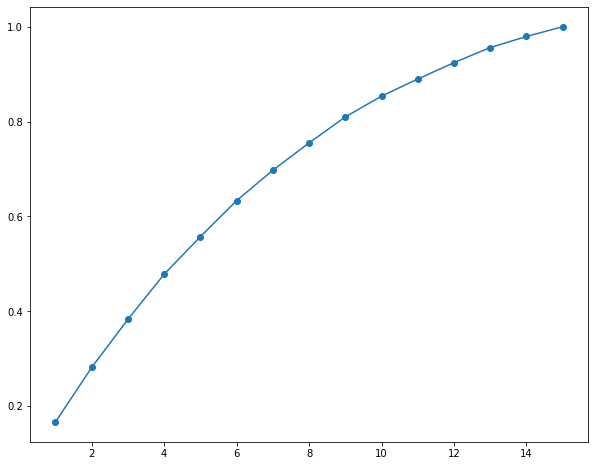

In [200]:
plt.figure(figsize=(10,8))
plt.plot(range(1,16),PCA().fit(df_std).explained_variance_ratio_.cumsum(), marker = 'o')

In [201]:
# take first 8 Principal components
pca_2d = PCA(n_components=8).fit_transform(df_std)


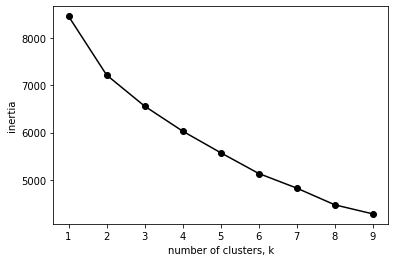

In [202]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(pca_2d)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [203]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=123)
y_km = kmeans.fit_predict(df_std)

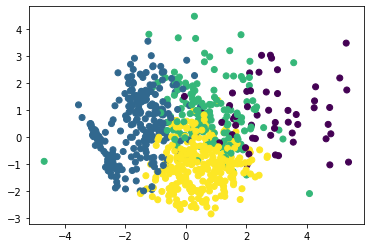

In [204]:
plt.figure('K-means with 3 clusters')
plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=kmeans.labels_)
plt.show()

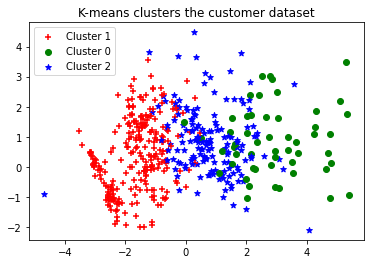

In [205]:
for i in range(0, pca_2d.shape[0]):
    if kmeans.labels_[i] == 1:
        c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',marker='+')
    elif kmeans.labels_[i] == 0:
        c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g', marker='o')
    elif kmeans.labels_[i] == 2:
        c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b', marker='*')
        
plt.legend([c1, c2, c3],['Cluster 1', 'Cluster 0','Cluster 2'])
plt.title('K-means clusters the customer dataset')
plt.show()

In [206]:
df_pca = pd.DataFrame(pca_2d)
df_pca['y_km']=y_km

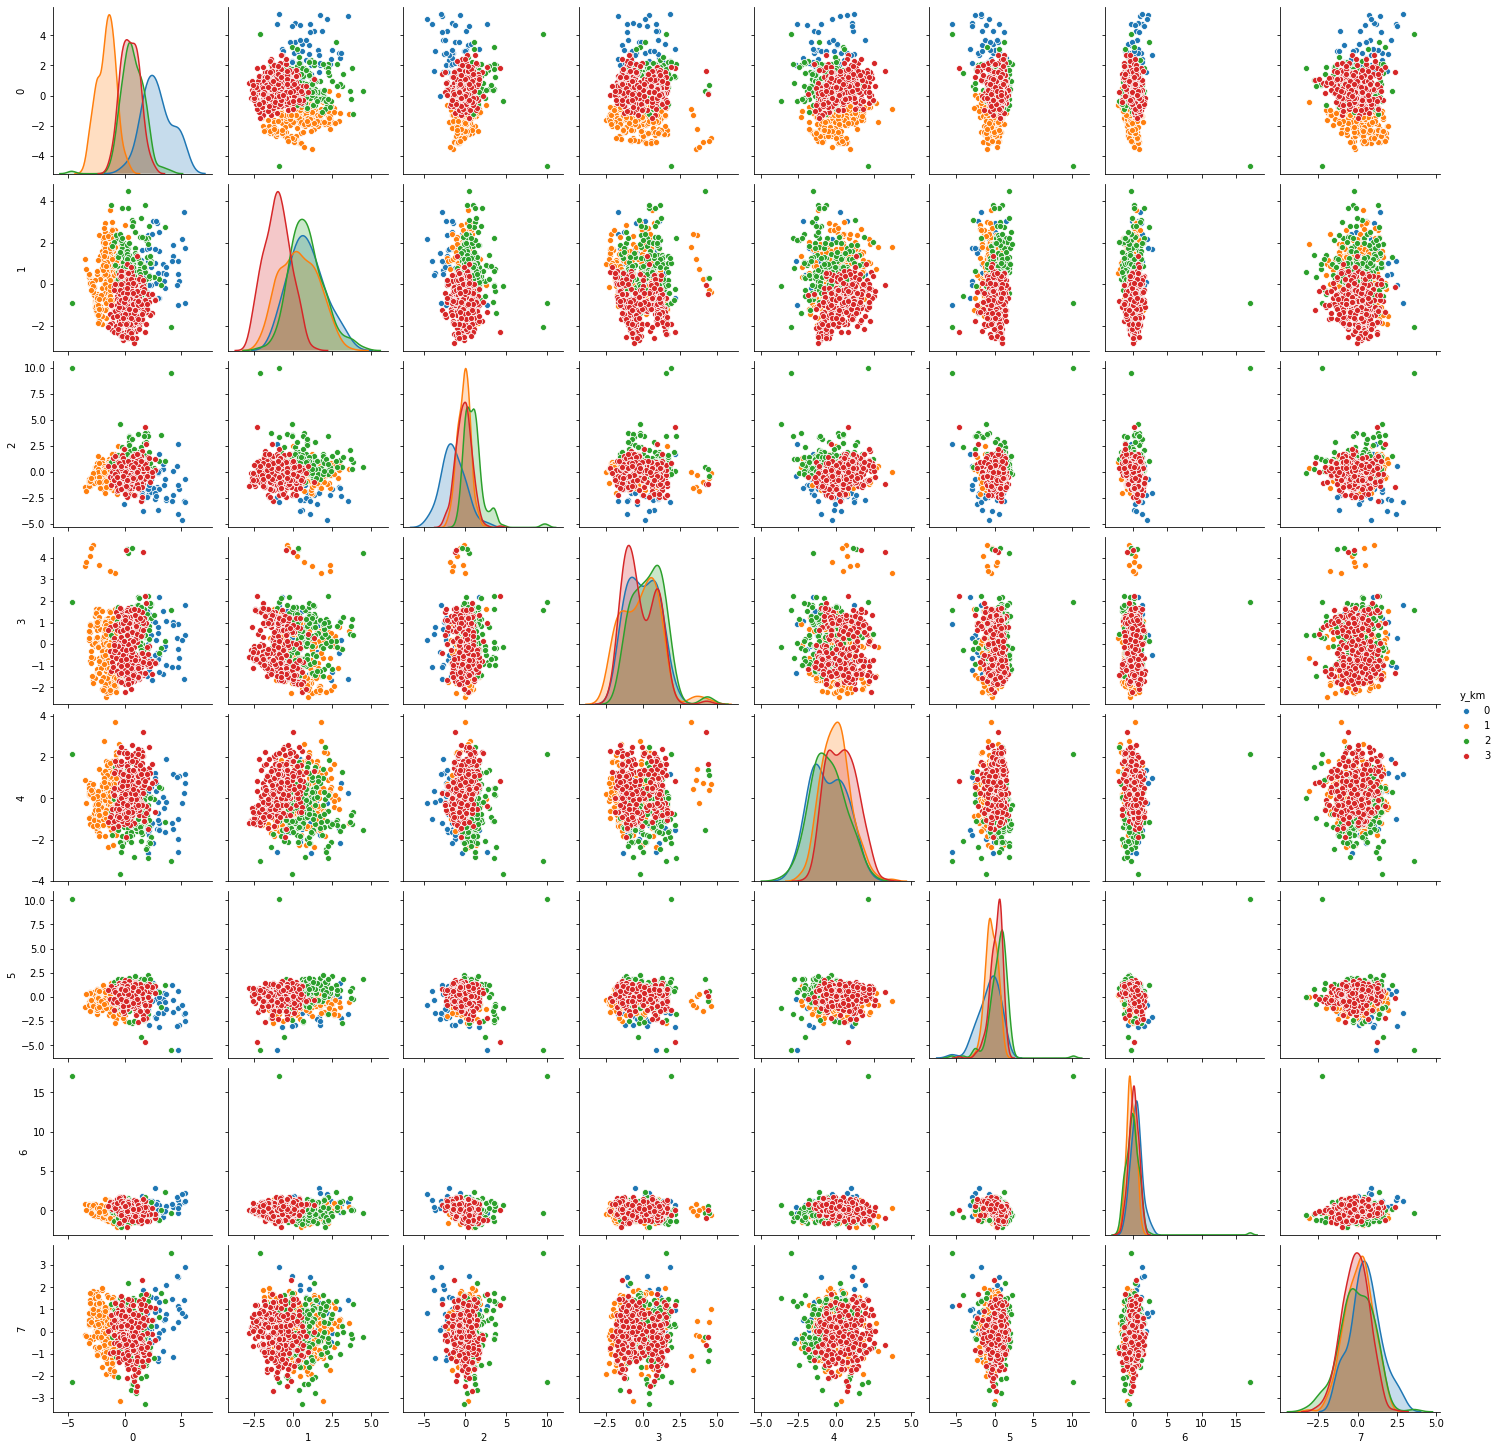

In [207]:
sns.pairplot(df_pca,hue='y_km')

In [208]:
df_full = df_std

In [209]:
df_full['segment_kmeans_pca'] = kmeans.labels_

In [210]:
df_full['segment']=df_full['segment_kmeans_pca'].map({0:'first',1:'second',2:'third'})

In [211]:
df_full.head()

,income,age,years_with_bank,nbr_children,marital_status,tran_amt,tran_id,avg_amt,M,Lat,Long,CC,cc_balance,SV,ending_balance,segment_kmeans_pca,segment
0,0.154185,0.184312,0.408539,0.258591,0.132149,0.318045,-1.603560,0.015394,1.127172,-0.185145,-0.924589,-1.295152,-0.608137,-1.136403,-0.426558,1,second
1,-0.726524,1.493070,-1.087435,-0.648298,0.132149,-1.066006,-0.012798,-0.307381,1.127172,-0.610743,-1.088833,0.772110,0.660202,0.879970,-0.418803,3,NaN
2,-0.188366,-0.234490,1.530520,-0.648298,-0.989614,0.469779,0.187978,0.046814,-0.887176,-0.610743,-1.088833,0.772110,-0.373275,0.879970,-0.352837,3,NaN
3,1.123798,0.603115,-0.339448,-0.648298,-0.989614,1.070537,0.249755,0.166021,-0.887176,-0.610743,-1.088833,0.772110,-0.608137,0.879970,-0.059979,3,NaN
4,0.983479,0.864867,1.904514,1.165479,2.375675,0.920392,0.450531,0.124181,-0.887176,0.727834,1.252063,0.772110,-0.551873,0.879970,-0.273737,2,third


## Make radar chart

In [212]:
df_1 = df_full[df_full['segment'] == 'first']
df_2 = df_full[df_full['segment'] == 'second']
df_3 = df_full[df_full['segment'] == 'third']

In [213]:
df_1_mean = df_1.mean()
df_2_mean = df_2.mean()
df_3_mean = df_3.mean()

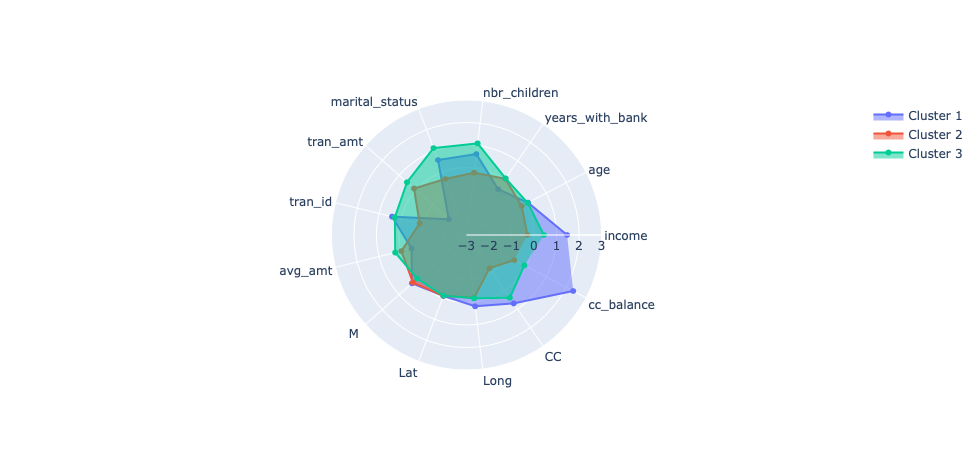

In [215]:
import plotly.graph_objects as go

categories = df.columns[:-2]

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=df_1_mean,
      theta=categories,
      fill='toself',
      name='Cluster 1'
))

fig.add_trace(go.Scatterpolar(
      r=df_2_mean,
      theta=categories,
      fill='toself',
      name='Cluster 2'
))

fig.add_trace(go.Scatterpolar(
      r=df_3_mean,
      theta=categories,
      fill='toself',
      name='Cluster 3'
))


fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-3, 3]
    )),
  showlegend=True
)

fig.show()

### visualize in 2D how our clusters are evolving in each iteration of KMeans (for at least 20 iterations).

In [228]:
kmeans = KMeans(n_clusters=3, random_state=123)
y_km = kmeans.fit_predict(df_std)

In [229]:
df_pca = df_pca[[0,1]]
X = np.array(df_pca)

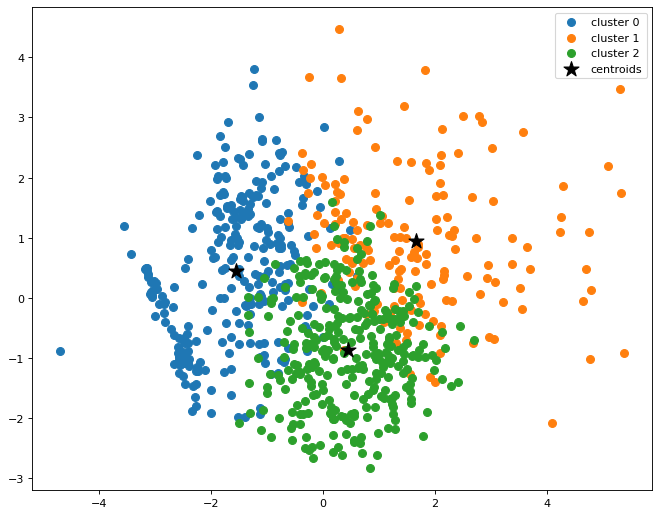

In [230]:
def show_plot_clusters(X,y_res, plt_cluster_centers = False):
    X_centroids = []
    Y_centroids = []

    plt.figure(figsize=(10, 8), dpi=80)
    for cluster in set(y_res):
        x = X[y_res == cluster,0]
        y = X[y_res == cluster,1]
        X_centroids.append(np.mean(x))
        Y_centroids.append(np.mean(y))

        
        plt.scatter(x,
                    y,
                    s=50,
                    marker='o',
                    label=f'cluster {cluster}')

    if plt_cluster_centers:
        plt.scatter(X_centroids,
                    Y_centroids,
                    marker='*',
                    c='black',
                    s=200,
                    label='centroids')

    plt.legend()
    plt.show()
    
    
    
show_plot_clusters(X, y_km, plt_cluster_centers= True)

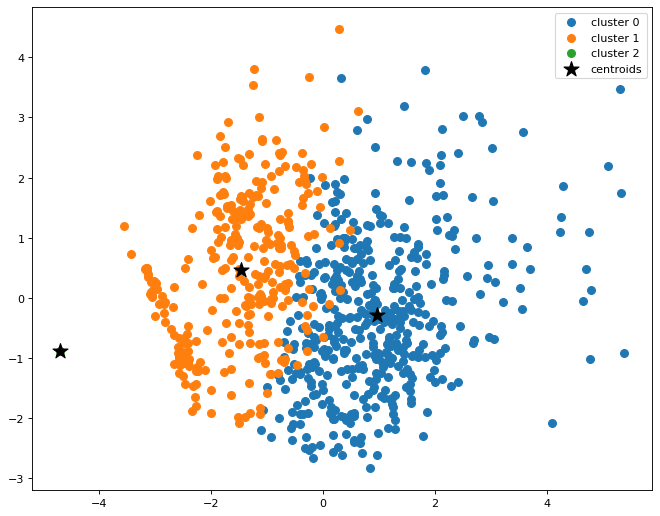

In [227]:
from IPython.display import clear_output

for i in range(1,20):
    clear_output()
    kmeans = KMeans(n_clusters=3, random_state=11, n_init=i)
    y_km = kmeans.fit_predict(df_std)
    show_plot_clusters(X, y_km, plt_cluster_centers= True)
    time.sleep(0.5)
   

In [220]:
df_std.head()

,income,age,years_with_bank,nbr_children,marital_status,tran_amt,tran_id,avg_amt,M,Lat,Long,CC,cc_balance,SV,ending_balance,segment_kmeans_pca,segment
0,0.154185,0.184312,0.408539,0.258591,0.132149,0.318045,-1.603560,0.015394,1.127172,-0.185145,-0.924589,-1.295152,-0.608137,-1.136403,-0.426558,1,second
1,-0.726524,1.493070,-1.087435,-0.648298,0.132149,-1.066006,-0.012798,-0.307381,1.127172,-0.610743,-1.088833,0.772110,0.660202,0.879970,-0.418803,3,NaN
2,-0.188366,-0.234490,1.530520,-0.648298,-0.989614,0.469779,0.187978,0.046814,-0.887176,-0.610743,-1.088833,0.772110,-0.373275,0.879970,-0.352837,3,NaN
3,1.123798,0.603115,-0.339448,-0.648298,-0.989614,1.070537,0.249755,0.166021,-0.887176,-0.610743,-1.088833,0.772110,-0.608137,0.879970,-0.059979,3,NaN
4,0.983479,0.864867,1.904514,1.165479,2.375675,0.920392,0.450531,0.124181,-0.887176,0.727834,1.252063,0.772110,-0.551873,0.879970,-0.273737,2,third


In [222]:
df_std = df_std.drop(['segment_kmeans_pca','segment'], axis=1)

income            -1.024149
age               -1.543248
years_with_bank   -1.461429
nbr_children      -0.648298
marital_status    -0.989614
tran_amt          -4.895651
tran_id           -1.603560
avg_amt           -1.756089
M                 -0.887176
Lat               -3.172176
Long              -3.185093
CC                -1.295152
cc_balance        -0.608137
SV                -1.136403
ending_balance    -0.426558
dtype: float64